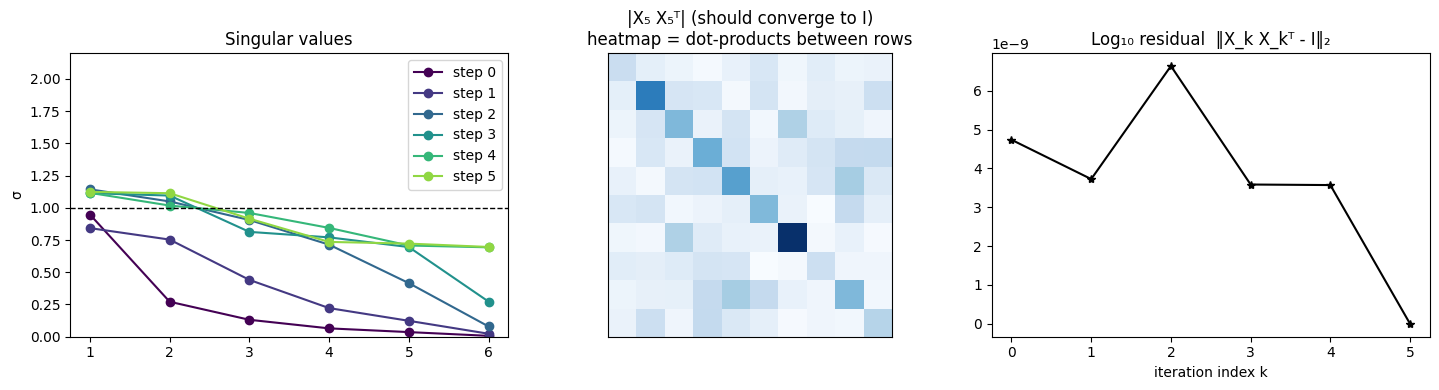

In [1]:
import numpy as np
import torch, torch.nn.functional as F
import matplotlib.pyplot as plt

# ---- replicate the Newton–Schulz iteration ----
def newtonschulz_np(G, steps=5):
    G_b = torch.tensor(G, dtype=torch.bfloat16).cuda()
    G_b /= (G_b.norm() + 1e-7)
    trans = False
    if G_b.size(0) > G_b.size(1):
        G_b = G_b.T; trans = True
    a,b,c = 3.4445, -4.7750, 2.0315
    X = G_b.clone()
    seq = [X.float().detach().cpu().numpy()]
    for _ in range(steps):
        A = X @ X.T
        B = b*A + c*A@A
        X = a*X + B@X
        seq.append(X.float().detach().cpu().numpy())
    if trans: seq = [s.T for s in seq]
    return seq      # list of X_0 … X_5 in double precision

# ---- synthetic example ----
n, m = 10, 6
np.random.seed(42)
G = np.random.randn(n, m) @ np.diag(np.logspace(-1, 1, m))*0.8   # skew spectrum
seq = newtonschulz_np(G, 5)

# ---- extract singular values ----
sing_vals = [np.linalg.svd(S, compute_uv=False) for S in seq]
K = 6
steps = len(seq)

# ---- build figure ----
fig, ax = plt.subplots(1, 3, figsize=(14.5, 4))

cmap = plt.cm.viridis

# left: singular values
for k, sig in enumerate(sing_vals):
    ax[0].plot(np.arange(1, len(sig)+1), sig, 'o-', color=cmap(k/steps), label=f'step {k}')
ax[0].axhline(1, color='k', ls='--', lw=1)
ax[0].set_ylim(0, 2.2); ax[0].set_title('Singular values'); ax[0].legend(); ax[0].set_ylabel('σ')

# middle: orthogonality of rows (10×10 correlation)
corr = seq[-1] @ seq[-1].T
im = ax[1].matshow(np.abs(corr), vmin=0, vmax=1, cmap='Blues')
ax[1].set_title('|X₅ X₅ᵀ| (should converge to I)\nheatmap = dot-products between rows'); ax[1].set_xticks([]); ax[1].set_yticks([])

# right: residual log10 error
res = [np.linalg.norm(S@S.T - np.eye(S.shape[0]), 2) for S in seq]
ax[2].plot(np.arange(steps), np.log10(res), 'k*-')
ax[2].set_title('Log₁₀ residual  ‖X_k X_kᵀ - I‖₂'); ax[2].set_xticks(range(steps))
ax[2].set_xlabel('iteration index k')
plt.tight_layout()
plt.show()

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# -----------------------------------------------------------
# Re-implementation of the 5-stage Newton–Schulz iteration
# -----------------------------------------------------------
def newtonschulz5_np(G, steps=5, eps=1e-7):
    """Returns a list [X₀, …, X₅] on the CPU."""
    G_t = torch.tensor(G, dtype=torch.bfloat16).cuda()
    G_t /= (G_t.norm() + eps)

    transpose = False
    if G_t.size(0) > G_t.size(1):
        G_t = G_t.T
        transpose = True

    a, b, c = 3.4445, -4.7750, 2.0315
    X = G_t.clone()

    seq = [X.float().detach().cpu().numpy()]
    for _ in range(steps):
        A = X @ X.T
        B = b * A + c * A @ A
        X = a * X + B @ X
        seq.append(X.float().detach().cpu().numpy())

    # undo transpose if we flipped dimension order
    if transpose:
        seq = [s.T for s in seq]
    return seq


# -----------------------------------------------------------
# Synthetic test matrix with skew spectrum
# -----------------------------------------------------------
np.random.seed(42)
n, m = 10, 6                                  # n ≥ m for display convenience
G = np.random.randn(n, m) @ np.diag(np.logspace(-1, 1, m)) * 0.8
seq = newtonschulz5_np(G, steps=5)

# singular values at each k
sig_k = [np.linalg.svd(S, compute_uv=False) for S in seq]

# -----------------------------------------------------------
# figure creation
# -----------------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(15, 4.3))
cmap = plt.cm.viridis

# 1. Singular-value convergence (σ_i(X_k))
for k, σ in enumerate(sig_k):
    axes[0].plot(np.arange(1, len(σ)+1), σ, 'o-',
                 color=cmap(k/5), label=f'k = {k}')
axes[0].axhline(1, ls='--', c='k', lw=1)
axes[0].set_xlabel('singular-value index $i$', fontsize=12)
axes[0].set_ylabel(r'$\sigma_i\bigl(X^{(k)}\bigr)$', fontsize=13)
axes[0].set_title(r'Convergence of singular values to $1$', fontsize=13)
axes[0].legend(ncols=2, fontsize=9)
axes[0].set_ylim(bottom=0, top=2.2)

# 2. Orthogonality check (|X₅X₅ᵀ| heat-map)
corr = np.abs(seq[-1] @ seq[-1].T)
im1 = axes[1].matshow(corr, vmin=0, vmax=1, cmap='Blues')
axes[1].set_title(r'$|X_k^{\vphantom{\sf T}}X_k^{\sf T}|$  at  $k=5$  (identity sought)', fontsize=12)
axes[1].set_xlabel(r'index $j$', fontsize=11)
axes[1].set_ylabel(r'index $i$', fontsize=11)
axes[1].set_xticks(range(0, n, 2))
axes[1].set_yticks(range(0, n, 2))
fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

# 3. Log₁₀ residual ‖X_kX_kᵀ − I‖₂
res = [np.linalg.norm(S @ S.T - np.eye(S.shape[0]), ord=2) for S in seq]
axes[2].plot(np.arange(6), np.log10(np.maximum(res, 1e-18)),
             'k*-')
axes[2].set_title(r'Log$_{10}$ residual  $\|X_kX_k^{\sf T}-I_n\|_{2}$', fontsize=12)
axes[2].set_xlabel('iteration index  $k$', fontsize=12)
axes[2].set_ylabel(r'$\log_{10}\!\bigl(\text{residual}\bigr)$', fontsize=12)
axes[2].set_xticks(range(6))
axes[2].grid(visible=True, ls=':', lw=0.5, alpha=0.7)

plt.tight_layout()
plt.show()

ValueError: 
\sigma_i\bigl(X^{(k)}\bigr)
        ^
ParseFatalException: Unknown symbol: \bigl, found '\'  (at char 8), (line:1, col:9)

Error in callback <function _draw_all_if_interactive at 0x706299880540> (for post_execute), with arguments args (),kwargs {}:


ValueError: 
\sigma_i\bigl(X^{(k)}\bigr)
        ^
ParseFatalException: Unknown symbol: \bigl, found '\'  (at char 8), (line:1, col:9)

ValueError: 
\sigma_i\bigl(X^{(k)}\bigr)
        ^
ParseFatalException: Unknown symbol: \bigl, found '\'  (at char 8), (line:1, col:9)

<Figure size 1500x430 with 4 Axes>

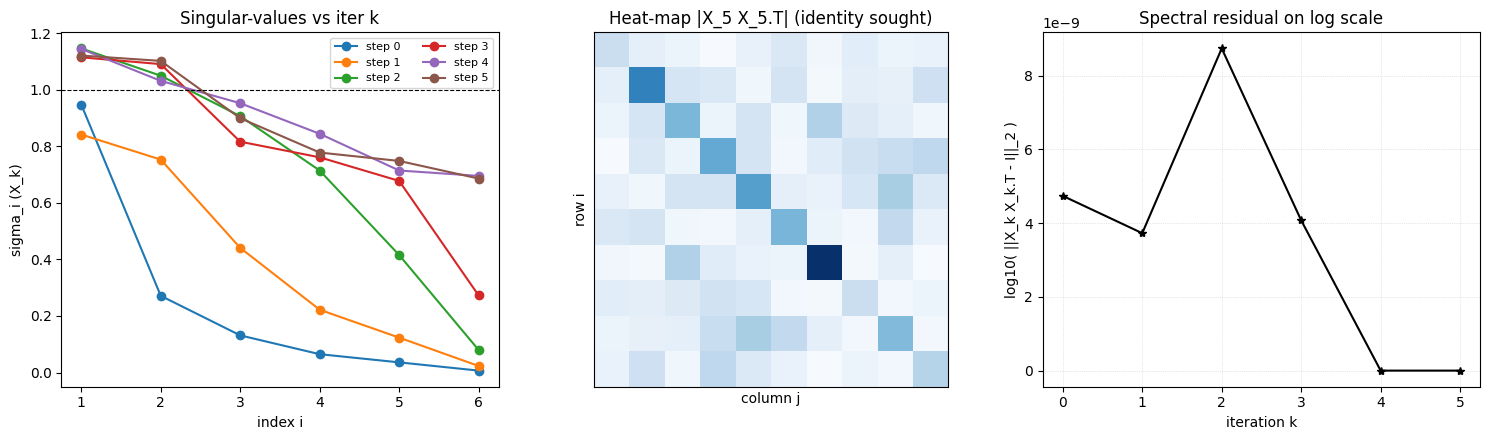

In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# -----------------------------------------------------------
# Replicate Newton-Schulz 5-step iteration in bfloat16
# -----------------------------------------------------------
def newtonschulz5_np(G, steps=5, eps=1e-7):
    G_t = torch.tensor(G, dtype=torch.bfloat16).cuda()
    G_t /= (G_t.norm() + eps)

    transpose = False
    if G_t.size(0) > G_t.size(1):
        G_t = G_t.T
        transpose = True

    a, b, c = 3.4445, -4.7750, 2.0315
    X = G_t.clone()

    seq = [X.float().detach().cpu().numpy()]
    for _ in range(steps):
        A = X @ X.T
        B = b * A + c * (A @ A)
        X = a * X + B @ X
        seq.append(X.float().detach().cpu().numpy())

    if transpose:
        seq = [s.T for s in seq]
    return seq

# -----------------------------------------------------------
# Synthetic example with skew spectrum
# -----------------------------------------------------------
np.random.seed(42)
n, m = 10, 6
G = np.random.randn(n, m) @ np.diag(np.logspace(-1, 1, m))*0.8
seq = newtonschulz5_np(G, steps=5)
sig_k = [np.linalg.svd(S, compute_uv=False) for S in seq]

# -----------------------------------------------------------
# Figure (crash-free labels)
# -----------------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(15, 4.5))

# 1. Singular–value convergence
for k, σ in enumerate(sig_k):
    axes[0].plot(np.arange(1, len(σ)+1), σ, 'o-', label=f'step {k}')
axes[0].set_xlabel('index i')
axes[0].set_ylabel('sigma_i (X_k)')
axes[0].set_title('Singular-values vs iter k')
axes[0].legend(ncols=2, fontsize=8)
axes[0].axhline(1, ls='--', c='k', lw=0.8)

# 2. |X_k X_k.T| heat-map for k = 5
axes[1].matshow(np.abs(seq[-1] @ seq[-1].T), vmin=0, vmax=1, cmap='Blues')
axes[1].set_xlabel('column j')
axes[1].set_ylabel('row i')
axes[1].set_title('Heat-map |X_5 X_5.T| (identity sought)')
axes[1].set_xticks([])         # keep figure tidy
axes[1].set_yticks([])

# 3. Residual on log_10 scale
res = [np.linalg.norm(S @ S.T - np.eye(S.shape[0]), ord=2) for S in seq]
axes[2].plot(range(len(res)), np.log10(np.maximum(res, 1e-18)), 'k*-')
axes[2].set_xlabel('iteration k')
axes[2].set_ylabel('log10( ||X_k X_k.T - I||_2 )')
axes[2].set_title('Spectral residual on log scale')
axes[2].grid(True, ls=':', lw=0.5, alpha=0.6)

plt.tight_layout()
plt.show()

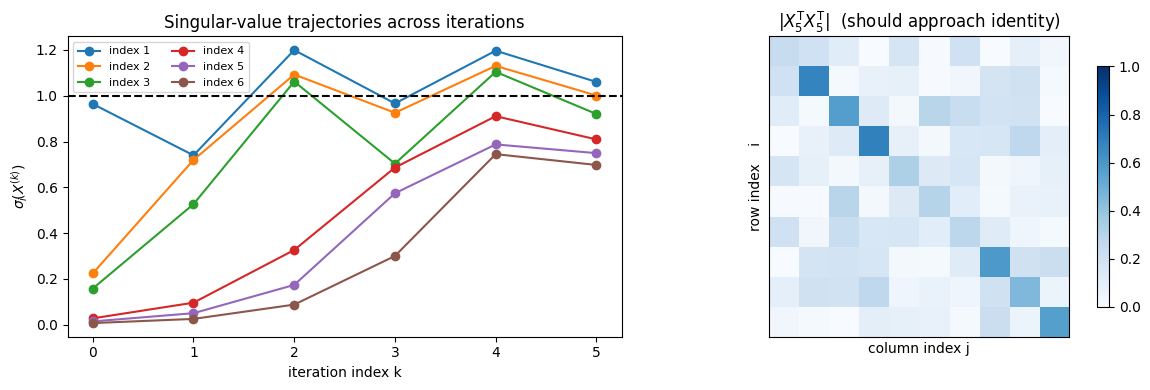

In [15]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# -----------------------------------------------------------
# Replicate Newton–Schulz 5-step iteration in bfloat16
# -----------------------------------------------------------
def newtonschulz5_np(G, steps=5, eps=1e-7):
    G_t = torch.tensor(G, dtype=torch.bfloat16).cuda()
    G_t /= (G_t.norm() + eps)

    transpose = False
    if G_t.size(0) > G_t.size(1):
        G_t = G_t.T
        transpose = True

    a, b, c = 3.4445, -4.7750, 2.0315
    X = G_t.clone()

    seq = [X.float().detach().cpu().numpy()]
    for _ in range(steps):
        A = X @ X.T
        B = b * A + c * (A @ A)
        X = a * X + B @ X
        seq.append(X.float().detach().cpu().numpy())

    if transpose:
        seq = [s.T for s in seq]
    return seq

# -----------------------------------------------------------
# Synthetic example
# -----------------------------------------------------------
np.random.seed(4424)
n, m = 10, 6
G = np.random.randn(n, m) @ np.diag(np.logspace(-1, 1, m)) * 0.8
seq = newtonschulz5_np(G, steps=5)

# Build matrix S[i,k] = σ_i(X_k)  (shape n_steps+1 × min(m,n))
sing = np.array([np.linalg.svd(S, compute_uv=False) for S in seq]).T  # index=i, iter=k

# -----------------------------------------------------------
# Proper panel 1: each singular-value trajectory (x = iteration index)
# -----------------------------------------------------------
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

for i, σ in enumerate(sing):
    ax[0].plot(σ, marker='o', label=f'index {i+1}')
ax[0].axhline(1, ls='--', c='k')
ax[0].set_xlabel('iteration index k')
ax[0].set_ylabel(r'$\sigma_i\!(X^{(k)})$')
ax[0].set_title('Singular-value trajectories across iterations')
ax[0].legend(ncols=2, fontsize=8)
ax[0].set_xticks(range(sing.shape[1]))
ax[0].set_xticklabels(range(sing.shape[1]))

# Panel 2: final |X_5 X_5.T| heat-map  (eye-check)
corr = np.abs(seq[-1] @ seq[-1].T)
im = ax[1].matshow(corr, vmin=0, vmax=1, cmap='Blues')
ax[1].set_title(r'$|X_5^{\sf T} X_5^{\sf T}|$  (should approach identity)')
ax[1].set_xlabel('column index j')
ax[1].set_ylabel('row index    i')
ax[1].set_xticks([])
ax[1].set_yticks([])
fig.colorbar(im, ax=ax[1], shrink=0.8)

plt.tight_layout()
plt.show()


In [17]:
!uv add seaborn

Resolved 202 packages in 878ms                                       
   Building lerobot-sim2real @ file:///home/thomas/src/lerobot-sim2real⠋ Preparing packages... (0/0)                                                   
   Building lerobot-sim2real @ file:///home/thomas/src/lerobot-sim2real
   Building lerobot-sim2real @ file:///home/thomas/src/lerobot-sim2real
      Built lerobot-sim2real @ file:///home/thomas/src/lerobot-sim2real
Prepared 1 package in 437ms                                              
Uninstalled 1 package in 0.63ms
Installed 2 packages in 4ms                                 
 ~ lerobot-sim2real==0.1.0 (from file:///home/thomas/src/lerobot-sim2real)
 + seaborn==0.13.2


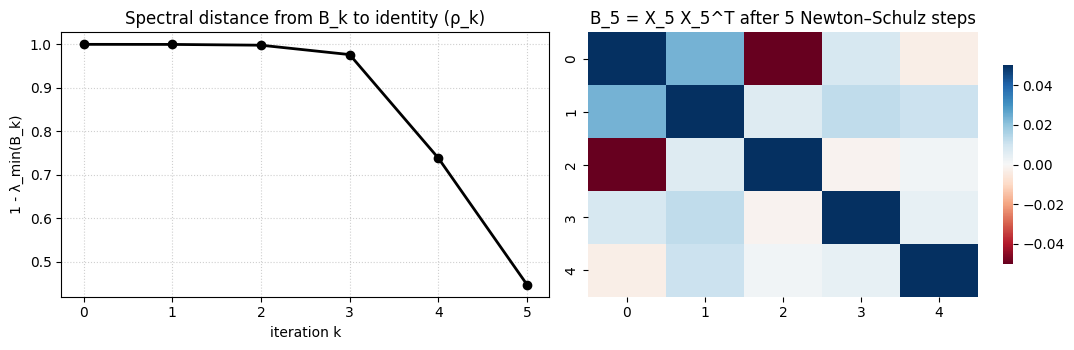

In [1]:
import numpy as np
import torch, matplotlib.pyplot as plt, seaborn as sns

def ns_with_spectral_monitor(G, steps=5, eps=1e-7):
    G_t = torch.tensor(G, dtype=torch.bfloat16, device='cuda') / (torch.tensor(G).norm() + eps)

    tall = G_t.shape[0] > G_t.shape[1]
    if tall:
        G_t = G_t.T

    a, b, c = 3.4445, -4.7750, 2.0315
    X = G_t.clone()

    # helpers to ship data back to CPU for plotting
    seq_X, seq_B, seq_rho = [], [], []

    for k in range(steps+1):
        B = (X @ X.T).float().cpu().numpy()
        rho = 1.0 - np.linalg.eigvals(B).real.min()
        seq_X.append(X.float().cpu().numpy())
        seq_B.append(B)
        seq_rho.append(rho)
        if k < steps:                                       # next iterate
            A = X @ X.T
            B_h = b*A + c*A@A
            X = a*X + B_h @ X
    if tall: seq_X = [S.T for S in seq_X]
    return seq_X, seq_B, seq_rho

# --------------------------------------------
# demo
np.random.seed(4424)
G = np.random.randn(12, 5) * np.logspace(-1,1,5)*0.7
X_traj, B_traj, rho_traj = ns_with_spectral_monitor(G, steps=5)

# --------------------------------------------
# panel A: ρ(k)  (distance to unit eigen-spectrum)
fig, ax = plt.subplots(1,2, figsize=(11,3.6))
ax[0].plot(rho_traj, 'ko-', lw=2)
ax[0].set_xticks(range(len(rho_traj)))
ax[0].set_xticklabels(range(len(rho_traj)))
ax[0].set_ylabel(r'1 - λ_min(B_k)')     # zero → B_k = I
ax[0].set_xlabel('iteration k')
ax[0].set_title('Spectral distance from B_k to identity (ρ_k)')
ax[0].grid(True, ls=':', alpha=.6)

# panel B: final B_k heat-map – clearly shows near-identity structure
sns.heatmap(B_traj[-1], vmin=-.05, vmax=.05,
            cmap='RdBu', center=0, ax=ax[1], cbar_kws={'shrink':.75})
ax[1].set_title('B_5 = X_5 X_5^T after 5 Newton–Schulz steps')
plt.tight_layout()
plt.show()